In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from random import shuffle
DT = 0.001
DAMP = 10

In [4]:
class Util:
    
    def magnitude(v):
        return np.linalg.norm(v)
    mag = length = dist = magnitude
    
    def normalized(v):
        return v / np.sqrt(np.sum(v**2))
    norm = normalized
    
    def c2i(x,y,n):
        return x * (n) + y
    
    def create_grid(N):
        g, pm = (0, -5), 10
        nodes = [(i//N, i%N) for i in range(N*N)]
        # edges = np.zeros(( (N-1)*(N-1) + 2*N) *4).reshape(((N-1)*(N-1) + 2*N), 2, 2)
        edges = []
        for x in range(N):
            for y in range(N):
                if x < (N - 1) and y < (N - 1):
                    edges.append((Util.c2i(x,y,N),Util.c2i(x+1,y,N)))
                    edges.append((Util.c2i(x,y,N),Util.c2i(x,y+1,N)))
#                     edges.append((Util.c2i(x,y,N),Util.c2i(x+1,y+1,N)))

                elif x < (N - 1) and y == (N - 1):
                    edges.append((Util.c2i(x,y,N),Util.c2i(x+1,y,N)))

                elif y < (N - 1) and x == (N - 1):
                    edges.append((Util.c2i(x,y,N),Util.c2i(x,y+1,N)))
        particles = []
        for p in nodes:
            if p == (0,N-1) or p == (N-1, N-1):
                particles.append(Particle(p, g, pm, lock = True))
            else:
                particles.append(Particle(p, g, pm))
        springs = [Spring(5, particles[ns[0]], particles[ns[1]]) for ns in edges]
        mesh = Mesh()
        mesh.batch_add(particles, springs)
        return mesh
    

In [5]:
class Particle:
    def __init__(self, pos = np.zeros(2), acc_i = np.zeros(2), m = 1, lock = False):
        self.pos = np.array(pos)
        self.acc_i = np.array(acc_i)
        self.acc = np.array(acc_i)
        self.pos_prev = self.pos # - np.array(vel_i) * DT - 0.5 * self.acc * DT * DT
        self.m = m
        self.lock = lock
        
    def aprox_vel(self):
        return (self.pos - self.pos_prev) / DT
    def verlet(self):
        if not self.lock:
            next_pos = self.pos * 2 - self.pos_prev + self.acc * DT * DT
            self.pos_prev, self.pos = self.pos, next_pos
    
    def apply_force(self, force):
         if not self.lock:
            self.acc = (force / self.m) + self.acc_i - DAMP * self.aprox_vel()
    
    def dir_to(self, other, norm=True):
        if norm:
            return Util.normalized(other.pos - self.pos)
        
        
    def __repr__(self):
        return "\n Particle: \n\t Position: " + str(self.pos) \
                + "\n\t Past Position: " + str(self.pos_prev) \
                + "\n\t Acceleration: " + str(self.acc) \
                + "\n\t Mass: " + str(self.m) \
                + "\n\t Achored: " + str(self.lock)

In [6]:
class Spring:
    
    def __init__(self, k, node1, node2, d=None):
        self.k = k
        self.node1 = node1
        self.node2 = node2
        if d == None:
            self.d = Util.length(self.node1.pos - self.node2.pos)
        else:
            self.d = d
            
    def apply_constraint(self):
        delta_pos = Util.length(self.node1.pos - self.node2.pos) - self.d
        force = self.k * delta_pos
        f_1t2 = self.node1.dir_to(self.node2) * force
        f_2t1 = self.node2.dir_to(self.node1) * force
        self.node2.apply_force(DAMP*f_2t1)
        self.node1.apply_force(DAMP*f_1t2)
        

    def __repr__(self):
        return "Spring " + str(self.spring_id) + ": \n\t Position1: " + str(self.node1.pos) \
                + "Position2: " + str(self.node2.pos) \
                + "\n\t Length: " + str(self.d) \
                + "\n\t k: " + str(self.k) 

In [7]:
a = np.array([0,1])
b = np.array([0,5])
Util.length(a-b)

4.0

In [8]:
class Mesh:
    def __init__(self, dt = 0.1):
        global DT 
        DT = dt
        self.particles = list()
        self.springs = list()
    
    def add_particle(self, particle):
        self.particles.append(particle)
        
    def add_spring(self, spring):
        self.springs.append(spring)
    
    def batch_add(self, particles, springs):
        self.particles += particles
        self.springs += springs
    
    def apply_constraints(self):
        for particle in self.particles:
            particle.verlet()
        for spring in self.springs:
            spring.apply_constraint()
        shuffle(self.springs)
        shuffle(self.particles)
            
        
    def display_mesh(self):
        x = []
        y = []
        for particle in self.particles:
            x.append(particle.pos[0])
            y.append(particle.pos[1])
            
        plt.plot(x, y, "o")
        
        lines = []
        for spring in self.springs:
            
            a = spring.node1.pos
            b = spring.node2.pos
            lines.append([a,b])
            
        lc = LineCollection(lines, color=["blue"], lw=0.2)
        
        plt.gca().add_collection(lc)
        plt.show()

    def run_static_loop(self, n, show=False):
        for _ in range(n):
            self.apply_constraints()
    
    

In [23]:



def mesh_construct0():
    p = [Particle((0,0), (0, -9.8), m = 10, lock = False),
        Particle((0,1), (0, -9.8), m = 10, lock = True)]
    s = [Spring(100, p[0], p[1], 1.1)]
    mesh = Mesh()
    mesh.particles = p
    mesh.springs = s
    mesh.display_mesh()
    mesh.run_static_loop(10000)
    for _ in range(10):
        mesh.run_static_loop(100)
        mesh.display_mesh()
        for i in mesh.particles:
            print(i)
            
def mesh_construct1():
    p = [Particle((0,0), (0,-9.8), 100, False),
        Particle((0,1), (0,-9.8), 1, True),
        Particle((1,1), (0,-9.8), 1, True),
        Particle((1,0), (0,-9.8), 100, False)]
    s = [Spring(100, p[0], p[1]),
        Spring(100, p[1], p[2]),
        Spring(100, p[2], p[3]),
        Spring(100, p[3], p[0], 1),
        Spring(100, p[0], p[2]),
        Spring(100, p[1], p[3])]
    mesh = Mesh()
    mesh.particles = p
    mesh.springs = s
    mesh.display_mesh()
    
    mesh.run_static_loop(10000)
            
    for _ in range(20):
        mesh.run_static_loop(50)
        mesh.display_mesh()
#         for i in mesh.particles:
#             print(i)


def mesh_construct2():
    mesh = Util.create_grid(20)
    mesh.display_mesh()
    
#     mesh.run_static_loop(10)
            
    for _ in range(20):
        mesh.run_static_loop(5)
        mesh.display_mesh()
#         for i in mesh.particles:
#             print(i)

def mesh_construct3():
    p = [Particle((1,1), (0, -9.8), m = 10, lock = False),
        Particle((0,3), (0, -9.8), m = 10, lock = True)]
    s = [Spring(100, p[0], p[1])]
    mesh = Mesh()
    mesh.particles = p
    mesh.springs = s
    mesh.display_mesh()
    for _ in range(10):
        mesh.run_static_loop(150)
        mesh.display_mesh()
        
        
def mesh_construct4(N):
        g, pm = (0, -5), 10
        nodes = [(i//N, i%N) for i in range(N*N)]
        # edges = np.zeros(( (N-1)*(N-1) + 2*N) *4).reshape(((N-1)*(N-1) + 2*N), 2, 2)
        edges = []
        for x in range(N):
            for y in range(N):
                if x < (N - 1) and y < (N - 1):
                    edges.append((Util.c2i(x,y,N),Util.c2i(x+1,y,N)))
                    edges.append((Util.c2i(x,y,N),Util.c2i(x,y+1,N)))
                    edges.append((Util.c2i(x,y,N),Util.c2i(x+1,y+1,N)))
                    edges.append((Util.c2i(x+1,y,N),Util.c2i(x,y+1,N)))

                elif x < (N - 1) and y == (N - 1):
                    edges.append((Util.c2i(x,y,N),Util.c2i(x+1,y,N)))

                elif y < (N - 1) and x == (N - 1):
                    edges.append((Util.c2i(x,y,N),Util.c2i(x,y+1,N)))
        particles = []
        anchors = [(0,N-1),(1, N-1),(N-2,N-1),(N-1,N-1)]
        for p in nodes:
            if p in anchors:
                particles.append(Particle(p, g, pm, lock = True))
            else:
                particles.append(Particle(p, g, pm))
        springs = [Spring(10, particles[ns[0]], particles[ns[1]]) for ns in edges]
        mesh = Mesh()
        mesh.batch_add(particles, springs)
        mesh.display_mesh()
        for _ in range(10):
            mesh.run_static_loop(150)
        mesh.display_mesh()

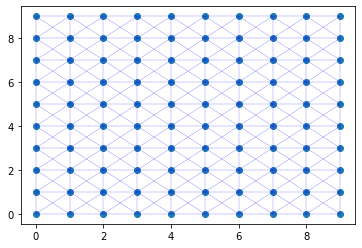

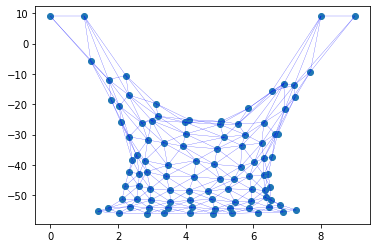

In [25]:
mesh_construct4(10)